In [1]:
import matplotlib.pyplot as plt

def show_history(history, model_name: str):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))  # 2 filas, 1 columna

    # Pérdida (loss)
    ax1.plot(history.history['loss'],     label='Training Loss',  color='green')
    ax1.plot(history.history['val_loss'], label='Validation Loss', color='blue')
    ax1.set_title('Loss evolution')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Precisión (accuracy)
    ax2.plot(history.history['accuracy'],     label='Training Accuracy',  color='green')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue')
    ax2.set_title('Accuracy evolution')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Título global
    fig.suptitle(model_name, fontsize=16)

    # Ajustar márgenes
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [2]:
import pickle
import pandas as pd
import numpy as np

pd.set_option("display.max_rows", None)   # Muestra todas las filas
pd.set_option("display.max_columns", None)  # Muestra todas las columnas
pd.set_option("display.width", None)     # No corta la tabla en varias líneas
pd.set_option("display.max_colwidth", None)  # Muestra el contenido de celdas completo

In [3]:
with open("../data/normalized/df_normalized.pk1", "rb") as f:
    df_data = pickle.load(f)

In [4]:
df_model = df_data.drop(columns=[
    "ride_id",
    "started_at",
    "ended_at",
    "start_station_id",
    "end_station_id",
    "member_casual",
    "month",
    "day", # Se va a usar day_type desglosado en dummies
    "time_hms_ms",
    "temperature",
    "wind_speed",
    "relative_humidity"
])

In [5]:
df_model.head()

,year,event,rideable_type_classic_bike,rideable_type_docked_bike,rideable_type_electric_bike,member_casual_bool,day_type_Holiday,day_type_Normal,day_type_Weekend,temp_std,wind_std,rel_humidity_std,start_station_idx,end_station_idx,hour_float,hour_sin,hour_cos,month_sin,month_cos,duration_min
0,2022,False,True,False,False,True,True,False,False,-0.996614,-1.035159,1.399734,1013,1013,0.001389,0.000364,1.000000,0.5,0.866025,1.716667
1,2022,False,False,False,True,True,True,False,False,-0.996614,-1.035159,1.399734,367,300,0.016667,0.004363,0.999990,0.5,0.866025,3.650000
2,2022,False,False,False,True,True,True,False,False,-0.996614,-1.035159,1.399734,1533,1533,0.021111,0.005527,0.999985,0.5,0.866025,30.966667
3,2022,False,True,False,False,True,True,False,False,-0.996614,-1.035159,1.399734,1013,1013,0.037222,0.009745,0.999953,0.5,0.866025,28.883333
4,2022,False,True,False,False,True,True,False,False,-0.996614,-1.035159,1.399734,1013,1013,0.043056,0.011272,0.999936,0.5,0.866025,28.483333


In [6]:
# Variables de entrada
X = df_model.drop(columns=['start_station_idx', 'end_station_idx'])
y_start = df_model['start_station_idx']
y_end   = df_model['end_station_idx']

In [7]:
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model

X_train, X_test, y_start_train, y_start_test, y_end_train, y_end_test = train_test_split(
    X, 
    y_start, 
    y_end, 
    test_size=0.2, 
    random_state=42
)

# ---------- Normalizar índices de estaciones con un offset común
station_offset = int(min(y_start.min(), y_end.min()))
# desplazamos todos para que el mínimo sea 0
y_start_train_shift = (y_start_train - station_offset).astype(int)
y_start_test_shift  = (y_start_test  - station_offset).astype(int)
y_end_train_shift   = (y_end_train   - station_offset).astype(int)
y_end_test_shift    = (y_end_test    - station_offset).astype(int)

num_stations = int(max(y_start.max(), y_end.max()) - station_offset + 1)
num_features = X.shape[1]

print(f"Number of stations: {num_stations}")
print(f"Number of features: {num_features}")

# ---------- Preparar inputs en la forma que requieren los Embeddings: (n,1)
X_train_context = X_train.values.astype(np.float32)
X_test_context  = X_test.values.astype(np.float32)

start_train_input = y_start_train_shift.values.reshape(-1, 1)
start_test_input  = y_start_test_shift.values.reshape(-1, 1)

# Si usas la estación final también como entrada (teacher forcing), la prepares:
end_train_input = y_end_train_shift.values.reshape(-1, 1)
end_test_input  = y_end_test_shift.values.reshape(-1, 1)

# Labels (etiquetas) para clasificación: estación destino (y_end)
y_train_labels = y_end_train_shift.values.astype(int)
y_test_labels  = y_end_test_shift.values.astype(int)

# ---------- Opcional: split del train en train/val
X_t_ctx, X_val_ctx, start_t_in, start_val_in, end_t_in, end_val_in, y_t, y_val = train_test_split(
    X_train_context,
    start_train_input,
    end_train_input,
    y_train_labels,
    test_size=0.2,
    random_state=42
)

# ---------- Construcción del modelo (inputs y embeddings)
embedding_dim = int(np.ceil(np.sqrt(num_stations)))

context_input = layers.Input(shape=(num_features,), name="context")
start_input   = layers.Input(shape=(1,), name="start_station_input")
end_input     = layers.Input(shape=(1,), name="end_station_input")

start_embed = layers.Embedding(input_dim=num_stations, output_dim=embedding_dim, name='start_embedding')(start_input)
start_embed = layers.Flatten()(start_embed)

end_embed = layers.Embedding(input_dim=num_stations, output_dim=embedding_dim, name='end_embedding')(end_input)
end_embed = layers.Flatten()(end_embed)

x = layers.Concatenate()([context_input, start_embed, end_embed])
x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)

end_output = layers.Dense(num_stations, activation='softmax', name='end_station')(x)

model = Model(inputs=[context_input, start_input, end_input], outputs=end_output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Number of stations: 1695
Number of features: 18


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ start_station_input │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ end_station_input   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ start_embedding     │ (None, 1, 42)     │     71,190 │ start_station_in… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ end_embedding       │ (None, 1, 42)     │     71,190 │ end_station_inpu… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context             │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 42)        │          0 │ start_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 42)        │          0 │ end_embedding[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 102)       │          0 │ context[0][0],    │
│ (Concatenate)       │                   │            │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     13,184 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ end_station (Dense) │ (None, 1695)      │    110,175 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 273,995 (1.05 MB)

 Trainable params: 273,995 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
%%time

# ---------- Callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# ---------- Entrenamiento usando validation_data (más explícito y claro)
history = model.fit(
    {'context': X_t_ctx, 'start_station_input': start_t_in, 'end_station_input': end_t_in},
    y_t,
    validation_data=(
        {'context': X_val_ctx, 'start_station_input': start_val_in, 'end_station_input': end_val_in},
        y_val
    ),
    epochs=20,
    batch_size=128,
    callbacks=[callback]
)

Epoch 1/20
49850/49850 ━━━━━━━━━━━━━━━━━━━━ 166s 3ms/step - accuracy: 0.1200 - loss: 4.1027 - val_accuracy: 0.3499 - val_loss: 2.9057
Epoch 2/20
49850/49850 ━━━━━━━━━━━━━━━━━━━━ 161s 3ms/step - accuracy: 0.5160 - loss: 2.2296 - val_accuracy: 0.7757 - val_loss: 1.1278
Epoch 3/20
49850/49850 ━━━━━━━━━━━━━━━━━━━━ 219s 4ms/step - accuracy: 0.8467 - loss: 0.7253 - val_accuracy: 0.9407 - val_loss: 0.3397
Epoch 4/20
49850/49850 ━━━━━━━━━━━━━━━━━━━━ 228s 4ms/step - accuracy: 0.9338 - loss: 0.3617 - val_accuracy: 0.9681 - val_loss: 0.2063
Epoch 5/20
49850/49850 ━━━━━━━━━━━━━━━━━━━━ 205s 4ms/step - accuracy: 0.9469 - loss: 0.2927 - val_accuracy: 0.9659 - val_loss: 0.2071
Epoch 6/20
49850/49850 ━━━━━━━━━━━━━━━━━━━━ 200s 4ms/step - accuracy: 0.9537 - loss: 0.2593 - val_accuracy: 0.9762 - val_loss: 0.1773
Epoch 7/20
49850/49850 ━━━━━━━━━━━━━━━━━━━━ 186s 4ms/step - accuracy: 0.9574 - loss: 0.2435 - val_accuracy: 0.9798 - val_loss: 0.1484
Epoch 8/20
49850/49850 ━━━━━━━━━━━━━━━━━━━━ 184s 4ms/step - ac

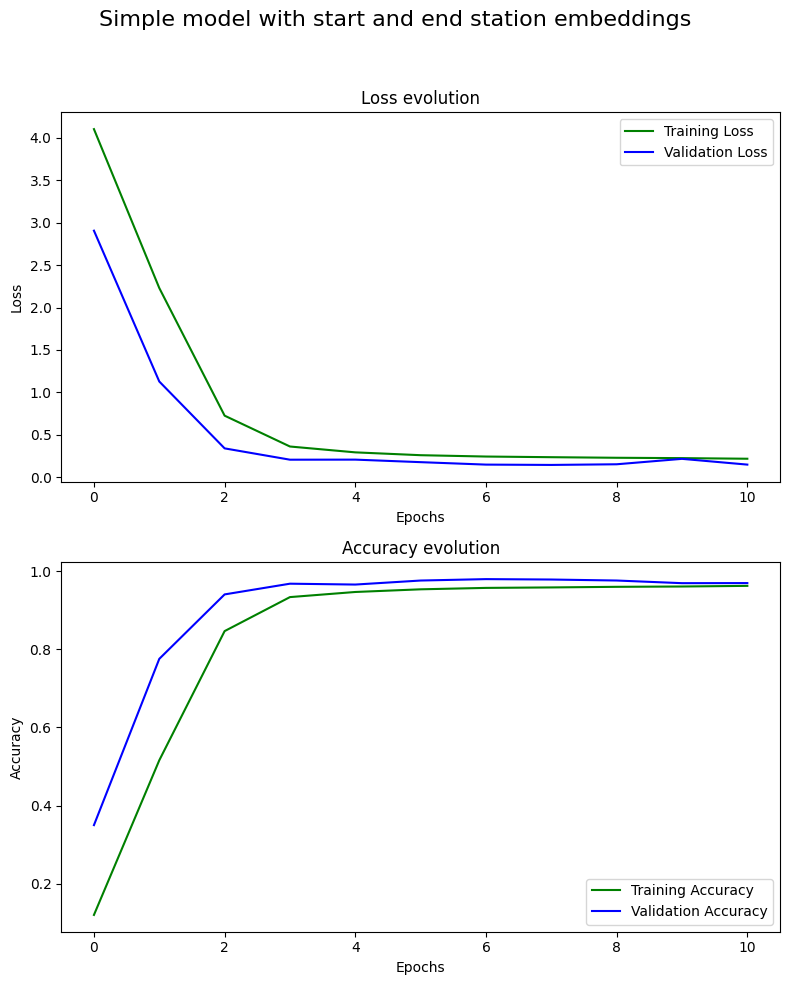

In [9]:
show_history(history, "Simple model with start and end station embeddings")

In [10]:
# ---------- Evaluación final sobre el test set real
test_metrics = model.evaluate(
    {'context': X_test_context, 'start_station_input': start_test_input, 'end_station_input': end_test_input},
    y_test_labels,
    verbose=2
)
print("Test metrics (loss, accuracy):", test_metrics)

62313/62313 - 76s - 1ms/step - accuracy: 0.9787 - loss: 0.1454
Test metrics (loss, accuracy): [0.14544038474559784, 0.9786834716796875]


In [11]:
model.save("modelSave/model_3.keras")